---

## 1. Problem Description and Deep Learning Approach

**Problem**: Binary classification to predict mortality (`DEATH_EVENT`) from clinical records of heart failure patients.

**Classical ML approach**: Logistic Regression, Random Forest, SVM with hand-crafted features.

**Deep Learning approach**: Multi-layer Perceptron (MLP) that learns hierarchical feature representations automatically. The network will:
- Take 12 input features (age, lab results, etc.)
- Learn non-linear transformations through hidden layers with activation functions
- Use backpropagation and gradient descent to optimize weights
- Apply regularization (dropout, batch normalization) to prevent overfitting
- Output a probability via sigmoid activation

**Why DL?**: Neural networks can capture complex non-linear interactions between features without manual feature engineering. Though this dataset is small, we'll demonstrate the full DL pipeline with proper validation and evaluation.

---

## 2. Install Dependencies & Import Libraries

Install required packages if needed. We use:
- **PyTorch**: Deep learning framework
- **scikit-learn**: For preprocessing (StandardScaler) and metrics
- **pandas**: Data manipulation
- **matplotlib/seaborn**: Visualization


In [16]:
# Install PyTorch if needed (uncomment the line below)
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
# !pip install scikit-learn pandas matplotlib seaborn

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, confusion_matrix, 
                             classification_report, roc_curve)

import warnings
warnings.filterwarnings('ignore')

# Print versions
print(f"PyTorch version: {torch.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")

PyTorch version: 2.10.0+cpu
Pandas version: 2.1.4
NumPy version: 1.26.4


In [17]:
!pip install torch

## 3. Set Reproducibility and Device

**Theory**: Neural networks use random initialization. Setting seeds ensures reproducibility of results.

**Device**: We check for GPU availability. GPUs accelerate matrix operations via parallel computing, but this small dataset works fine on CPU.

In [18]:
# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# For deterministic behavior (may impact performance)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


## 4. Load and Inspect Dataset

Load the heart failure clinical records dataset and perform exploratory data analysis (EDA).

In [19]:
# Load dataset
df = pd.read_csv('heart_failure_clinical_records_dataset.csv')

print("Dataset shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())

print("\nDataset info:")
print(df.info())

print("\nBasic statistics:")
print(df.describe())

print("\nMissing values:")
print(df.isnull().sum())

print("\nTarget variable distribution (DEATH_EVENT):")
print(df['DEATH_EVENT'].value_counts())
print(f"\nClass balance: {df['DEATH_EVENT'].value_counts(normalize=True)}")

Dataset shape: (299, 13)

First 5 rows:
    age  anaemia  creatinine_phosphokinase  diabetes  ejection_fraction  \
0  75.0        0                       582         0                 20   
1  55.0        0                      7861         0                 38   
2  65.0        0                       146         0                 20   
3  50.0        1                       111         0                 20   
4  65.0        1                       160         1                 20   

   high_blood_pressure  platelets  serum_creatinine  serum_sodium  sex  \
0                    1  265000.00               1.9           130    1   
1                    0  263358.03               1.1           136    1   
2                    0  162000.00               1.3           129    1   
3                    0  210000.00               1.9           137    1   
4                    0  327000.00               2.7           116    0   

   smoking  time  DEATH_EVENT  
0        0     4            1  


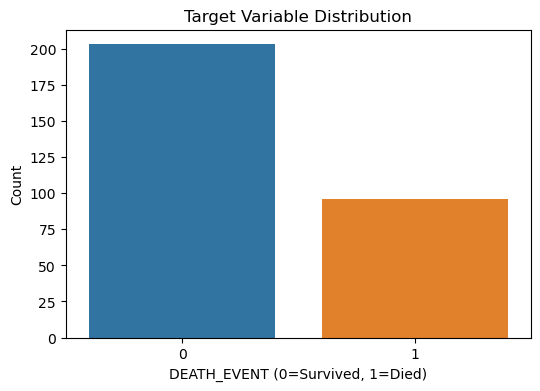

In [20]:
# Visualize target distribution
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='DEATH_EVENT')
plt.title('Target Variable Distribution')
plt.xlabel('DEATH_EVENT (0=Survived, 1=Died)')
plt.ylabel('Count')
plt.show()

## 5. Preprocessing and Feature Engineering

**Theory → Implementation**:

1. **Train/Val/Test Split (70/15/15)**: 
   - We split into three sets to prevent overfitting and evaluate generalization
   - Training set: Learn weights via gradient descent
   - Validation set: Tune hyperparameters and implement early stopping
   - Test set: Final unbiased performance estimate

2. **Stratified splitting**: 
   - Maintains class distribution across splits (important for imbalanced datasets)
   - Prevents train/val/test having different class proportions

3. **Feature Scaling (StandardScaler)**:
   - Neural networks are sensitive to feature scales
   - Standardization: $z = \frac{x - \mu}{\sigma}$ transforms features to mean=0, std=1
   - **Why?** Gradient descent converges faster when features are on similar scales
   - **Important**: Fit scaler only on training data, then transform val/test to prevent data leakage

In [21]:
# Separate features and target
X = df.drop('DEATH_EVENT', axis=1).values  # Features
y = df['DEATH_EVENT'].values  # Target

print(f"Feature shape: {X.shape}")
print(f"Target shape: {y.shape}")

# Split into train+val (85%) and test (15%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.15, random_state=SEED, stratify=y
)

# Split train+val into train (70% of total) and val (15% of total)
# 0.15 / 0.85 ≈ 0.176 to get 15% of original data
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.176, random_state=SEED, stratify=y_temp
)

print(f"\nTrain set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

print(f"\nTrain target distribution: {np.bincount(y_train)}")
print(f"Val target distribution: {np.bincount(y_val)}")
print(f"Test target distribution: {np.bincount(y_test)}")

Feature shape: (299, 12)
Target shape: (299,)

Train set: 209 samples
Validation set: 45 samples
Test set: 45 samples

Train target distribution: [142  67]
Val target distribution: [30 15]
Test target distribution: [31 14]


In [22]:
# Feature scaling using StandardScaler
# IMPORTANT: Fit only on training data to prevent data leakage!
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Fit and transform training data
X_val_scaled = scaler.transform(X_val)  # Only transform validation data
X_test_scaled = scaler.transform(X_test)  # Only transform test data

print("Training features scaled (mean ≈ 0, std ≈ 1):")
print(f"Mean: {X_train_scaled.mean(axis=0)[:3]}...")  # Show first 3 features
print(f"Std: {X_train_scaled.std(axis=0)[:3]}...")

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.FloatTensor(y_train).unsqueeze(1)  # Shape: (N, 1)

X_val_tensor = torch.FloatTensor(X_val_scaled)
y_val_tensor = torch.FloatTensor(y_val).unsqueeze(1)

X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.FloatTensor(y_test).unsqueeze(1)

print(f"\nTensor shapes:")
print(f"X_train: {X_train_tensor.shape}, y_train: {y_train_tensor.shape}")
print(f"X_val: {X_val_tensor.shape}, y_val: {y_val_tensor.shape}")
print(f"X_test: {X_test_tensor.shape}, y_test: {y_test_tensor.shape}")

Training features scaled (mean ≈ 0, std ≈ 1):
Mean: [ 2.44355307e-17  1.56174914e-16 -2.60291523e-17]...
Std: [1. 1. 1.]...

Tensor shapes:
X_train: torch.Size([209, 12]), y_train: torch.Size([209, 1])
X_val: torch.Size([45, 12]), y_val: torch.Size([45, 1])
X_test: torch.Size([45, 12]), y_test: torch.Size([45, 1])


## 6. Create PyTorch Dataset and DataLoader

**Theory → Implementation**:

- **Dataset**: Custom class that wraps data and returns (features, label) pairs
- **DataLoader**: Handles batching, shuffling, and parallel data loading
- **Batch size**: Number of samples processed before updating weights
  - Smaller batches: More frequent updates, noisier gradients, better regularization
  - Larger batches: More stable gradients, faster training, higher memory usage
  - We use batch_size=16 for this small dataset
- **Shuffling**: Randomize training samples each epoch to prevent learning order-dependent patterns

In [23]:
# Custom Dataset class
class HeartFailureDataset(Dataset):
    """
    Custom PyTorch Dataset for heart failure data.
    Wraps features and labels, returns individual samples.
    """
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# Create Dataset objects
train_dataset = HeartFailureDataset(X_train_tensor, y_train_tensor)
val_dataset = HeartFailureDataset(X_val_tensor, y_val_tensor)
test_dataset = HeartFailureDataset(X_test_tensor, y_test_tensor)

# Create DataLoader objects
BATCH_SIZE = 16

train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True,  # Shuffle training data
    num_workers=0,  # Use 0 for Windows compatibility
    drop_last=True  # Drop last incomplete batch to avoid BatchNorm errors
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False,  # No need to shuffle validation data
    num_workers=0
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    num_workers=0
)

print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")
print(f"Number of test batches: {len(test_loader)}")

Number of training batches: 13
Number of validation batches: 3
Number of test batches: 3


## 7. Define Neural Network Model (MLP)

**Architecture: Multi-Layer Perceptron (Feedforward Neural Network)**

**Theory → Implementation**:

1. **Linear layers**: Compute $y = xW^T + b$ (matrix multiplication + bias)
   
2. **ReLU activation**: $\text{ReLU}(x) = \max(0, x)$
   - Introduces non-linearity (without it, network would be equivalent to linear regression)
   - Allows network to learn complex, non-linear decision boundaries
   
3. **Batch Normalization**:
   - Normalizes activations within each mini-batch
   - Reduces internal covariate shift, stabilizes training
   - Acts as regularizer, allows higher learning rates
   
4. **Dropout**:
   - Randomly drops neurons during training with probability $p$
   - Prevents co-adaptation of neurons (overfitting)
   - Effectively trains an ensemble of sub-networks
   
5. **Output layer**: Single neuron (binary classification)
   - Returns logit (raw score before activation)
   - BCEWithLogitsLoss handles sigmoid internally (more numerically stable)

In [24]:
class HeartFailureMLPClassifier(nn.Module):
    """
    Multi-Layer Perceptron for binary classification.
    
    Architecture: Input → Hidden1 → Hidden2 → Output
    Each hidden layer: Linear → BatchNorm → ReLU → Dropout
    """
    def __init__(self, input_dim, hidden_dims=[64, 32], dropout_rate=0.3):
        """
        Args:
            input_dim: Number of input features
            hidden_dims: List of hidden layer sizes
            dropout_rate: Dropout probability
        """
        super(HeartFailureMLPClassifier, self).__init__()
        
        self.input_dim = input_dim
        self.hidden_dims = hidden_dims
        
        # First hidden layer
        self.fc1 = nn.Linear(input_dim, hidden_dims[0])
        self.bn1 = nn.BatchNorm1d(hidden_dims[0])
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_rate)
        
        # Second hidden layer
        self.fc2 = nn.Linear(hidden_dims[0], hidden_dims[1])
        self.bn2 = nn.BatchNorm1d(hidden_dims[1])
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout_rate)
        
        # Output layer (logit for binary classification)
        self.fc_out = nn.Linear(hidden_dims[1], 1)
        
    def forward(self, x):
        """
        Forward pass through the network.
        
        Args:
            x: Input features, shape (batch_size, input_dim)
        
        Returns:
            logits: Raw scores, shape (batch_size, 1)
        """
        # Hidden layer 1
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        
        # Hidden layer 2
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        
        # Output layer
        logits = self.fc_out(x)
        
        return logits

# Initialize model
input_dim = X_train.shape[1]  # 12 features
model = HeartFailureMLPClassifier(
    input_dim=input_dim,
    hidden_dims=[64, 32],  # Two hidden layers
    dropout_rate=0.3
).to(device)

print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters())}")

HeartFailureMLPClassifier(
  (fc1): Linear(in_features=12, out_features=64, bias=True)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc_out): Linear(in_features=32, out_features=1, bias=True)
)

Total parameters: 3137


In [25]:
# Loss function
criterion = nn.BCEWithLogitsLoss()  # Binary cross-entropy with logits

# Optimizer
LEARNING_RATE = 0.001
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min',  # Reduce LR when validation loss stops decreasing
    factor=0.5,  # Multiply LR by 0.5
    patience=5,  # Wait 5 epochs before reducing
)

# Training configuration
NUM_EPOCHS = 150
EARLY_STOPPING_PATIENCE = 20

print(f"Training configuration:")
print(f"  - Epochs: {NUM_EPOCHS}")
print(f"  - Learning rate: {LEARNING_RATE}")
print(f"  - Batch size: {BATCH_SIZE}")
print(f"  - Early stopping patience: {EARLY_STOPPING_PATIENCE}")

Training configuration:
  - Epochs: 150
  - Learning rate: 0.001
  - Batch size: 16
  - Early stopping patience: 20


## 9. Training Loop with Validation

**Training Process (per epoch)**:

1. **Forward pass**: Compute predictions $\hat{y} = f(x; \theta)$
2. **Compute loss**: $L(\hat{y}, y)$
3. **Backward pass**: Compute gradients $\frac{\partial L}{\partial \theta}$ via backpropagation
4. **Update weights**: $\theta \leftarrow \theta - \eta \nabla L$ (gradient descent)
5. **Validation**: Evaluate on validation set (no gradient computation)
6. **Track metrics**: Loss, accuracy for both train and validation sets

In [26]:
# Training and validation functions
def train_epoch(model, loader, criterion, optimizer, device):
    """Train for one epoch."""
    model.train()  # Set model to training mode (enables dropout, batch norm)
    running_loss = 0.0
    correct = 0
    total = 0
    
    for features, labels in loader:
        features, labels = features.to(device), labels.to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(features)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Track metrics
        running_loss += loss.item() * features.size(0)
        predictions = (torch.sigmoid(outputs) >= 0.5).float()
        correct += (predictions == labels).sum().item()
        total += labels.size(0)
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


def validate_epoch(model, loader, criterion, device):
    """Validate for one epoch."""
    model.eval()  # Set model to evaluation mode (disables dropout, batch norm)
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():  # Disable gradient computation
        for features, labels in loader:
            features, labels = features.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(features)
            loss = criterion(outputs, labels)
            
            # Track metrics
            running_loss += loss.item() * features.size(0)
            predictions = (torch.sigmoid(outputs) >= 0.5).float()
            correct += (predictions == labels).sum().item()
            total += labels.size(0)
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

In [27]:
# Training loop with early stopping
train_losses, val_losses = [], []
train_accs, val_accs = [], []

best_val_loss = float('inf')
patience_counter = 0
best_model_state = None

print("Starting training...\n")

for epoch in range(NUM_EPOCHS):
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validate
    val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)
    
    # Store metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    
    # Learning rate scheduling
    scheduler.step(val_loss)
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        best_model_state = model.state_dict().copy()
        print(f"Epoch {epoch+1}/{NUM_EPOCHS} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f} ← Best!")
    else:
        patience_counter += 1
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{NUM_EPOCHS} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
                  f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        
        if patience_counter >= EARLY_STOPPING_PATIENCE:
            print(f"\nEarly stopping triggered at epoch {epoch+1}")
            break

print(f"\nTraining completed!")
print(f"Best validation loss: {best_val_loss:.4f}")

# Load best model
model.load_state_dict(best_model_state)
print("Loaded best model checkpoint")

Starting training...



Epoch 1/150 - Train Loss: 0.7105, Train Acc: 0.5048 | Val Loss: 0.6827, Val Acc: 0.4889 ← Best!
Epoch 2/150 - Train Loss: 0.6503, Train Acc: 0.6346 | Val Loss: 0.6205, Val Acc: 0.7111 ← Best!
Epoch 3/150 - Train Loss: 0.5947, Train Acc: 0.7115 | Val Loss: 0.5676, Val Acc: 0.7556 ← Best!
Epoch 4/150 - Train Loss: 0.5419, Train Acc: 0.7837 | Val Loss: 0.5382, Val Acc: 0.7556 ← Best!
Epoch 5/150 - Train Loss: 0.5347, Train Acc: 0.7644 | Val Loss: 0.5044, Val Acc: 0.8222 ← Best!
Epoch 6/150 - Train Loss: 0.5087, Train Acc: 0.7933 | Val Loss: 0.4850, Val Acc: 0.7778 ← Best!
Epoch 7/150 - Train Loss: 0.4722, Train Acc: 0.7933 | Val Loss: 0.4644, Val Acc: 0.8222 ← Best!
Epoch 8/150 - Train Loss: 0.4703, Train Acc: 0.7885 | Val Loss: 0.4475, Val Acc: 0.7778 ← Best!
Epoch 9/150 - Train Loss: 0.4826, Train Acc: 0.7788 | Val Loss: 0.4299, Val Acc: 0.8000 ← Best!
Epoch 10/150 - Train Loss: 0.4456, Train Acc: 0.8365 | Val Loss: 0.4154, Val Acc: 0.7778 ← Best!
Epoch 11/150 - Train Loss: 0.4316, Trai

In [29]:
# Evaluate on test set
model.eval()
all_predictions = []
all_labels = []
all_probabilities = []

with torch.no_grad():
    for features, labels in test_loader:
        features = features.to(device)
        
        # Get predictions
        outputs = model(features)
        probabilities = torch.sigmoid(outputs)
        predictions = (probabilities >= 0.5).float()
        
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.numpy())
        all_probabilities.extend(probabilities.cpu().numpy())

# Convert to numpy arrays
y_true = np.array(all_labels).flatten()
y_pred = np.array(all_predictions).flatten()
y_prob = np.array(all_probabilities).flatten()

# Compute metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
roc_auc = roc_auc_score(y_true, y_prob)

print("=" * 50)
print("TEST SET PERFORMANCE")
print("=" * 50)
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print(f"ROC AUC:   {roc_auc:.4f}")
print("=" * 50)

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['Survived', 'Died']))

TEST SET PERFORMANCE
Accuracy:  0.7111
Precision: 0.5385
Recall:    0.5000
F1-Score:  0.5185
ROC AUC:   0.7972

Classification Report:
              precision    recall  f1-score   support

    Survived       0.78      0.81      0.79        31
        Died       0.54      0.50      0.52        14

    accuracy                           0.71        45
   macro avg       0.66      0.65      0.66        45
weighted avg       0.71      0.71      0.71        45



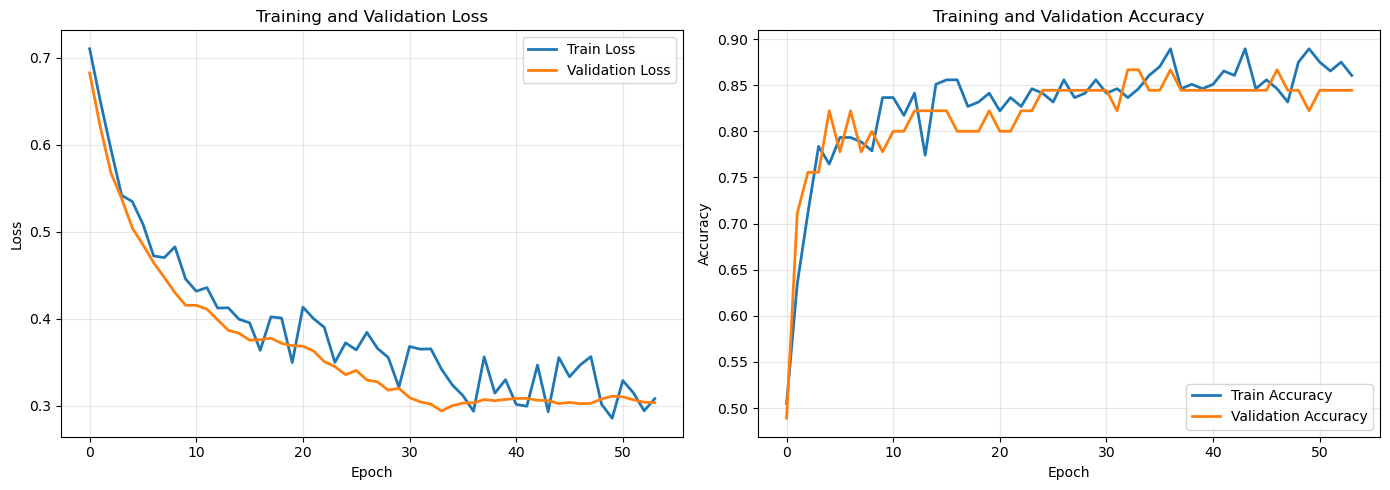

In [30]:
# Plot training curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss plot
axes[0].plot(train_losses, label='Train Loss', linewidth=2)
axes[0].plot(val_losses, label='Validation Loss', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy plot
axes[1].plot(train_accs, label='Train Accuracy', linewidth=2)
axes[1].plot(val_accs, label='Validation Accuracy', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Training and Validation Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Training and Validation Loss Analysis

### 1. Both Curves Decrease
- Training loss decreases steadily across epochs.
- Validation loss also decreases smoothly.
- This indicates that the model is learning meaningful patterns from the data.

### 2. Validation Loss is Close to Training Loss
- The validation curve closely follows the training curve.
- There is no significant gap between them.
- This suggests good generalization performance.
- A slightly lower validation loss may result from regularization techniques such as dropout

### 3. No Signs of Overfitting
- Overfitting would appear as decreasing training loss with increasing validation loss.
- In this case, both curves decrease and stabilize.
- Therefore, there is no clear evidence of overfitting.

### 4. Convergence Around Epoch 35–40
- Both losses plateau around 0.30.
- The model appears to have reached convergence.
- Early stopping around this range could be appropriate.

### 5. Small Oscillations in Training Loss
- Minor fluctuations are expected when using mini-batch gradient descent.
- There is no indication of instability in training.

---

### Overall Conclusion
The model demonstrates stable learning behavior, good generalization, and proper convergence. Training appears to be successful.